## Homework 1 - Number of Variants Per Genome 

<p>Author: <b>Rhondene Wint</b>   
Biostastics QSB285
Instructor: Dr.Huerta-Sanchez </p>

Task: Plot the number of variants per genome for each population using chromosome 21 from the 1000 Genomes dataset.

In [3]:
import pandas as pd
import sys
import os 
 

In [2]:
#read in populations for each individual from panel file I exported the original geogroup_v3.panel to geogroup.txt 

#read in population group for each  from panel file
geotable= pd.read_table(sys.argv[1] header=0, usecols = ['sample','pop'])  #this is the geogroup_v3.panel file
geogroup = geotable['pop'].unique() #stores all the populations

#extract all individual IDs
inds = geotable['sample'].unique()
ind_dict = dict()

# individual:count dictionary to record number of variant sites for each individual
for ind in inds:
    ind_dict[ind]=0

#generate a dictionary of population:individuals key:value pair
pop_dict = dict()
for group in geogroup:   
    sample = geotable[geotable['pop']==group]['sample'] 
    pop_dict[group] = sample  

pop_dict['variants']= {k:0 for (k,v) in pop_dict.items()}  #records total variants for each population; could be useful later 


In [ ]:
#to search for population of a individual
def reverse_lookup(dic, value):
    for key in dic:
        if value in dic[key].values:
            return key

In [7]:
#read vcf line by line and record variant sites per indivdidual and population

n=os.open("gunzip -c chr21.vcf.gz | grep -c '##'").readline() #number of header lines to skip over

with open(sys.argv[2], 'r+') as fh:  #sys.argv[1] is the  chr21.vcf file
    i =0;
    for line in fh:
        i+=1
        if (i == n):  
            col_ID = fh.readline().split('\t') 
            col_ID = col_ID[9:] #Column headings, the ID labels of each individual starts here
        if i > n:
            row = fh.readline().split('\t')
            try:  #i got an index error for some reason when I ran the whole vcf file, but did not appear on subset of data
                
                if len(row[3])==1 and len(row[4])==1: #bi-allelic sites, a single allele in ref column and alt column 
                    row=row[9:]
                    for x in range(len(row)):  #could also do for col in row
                        if (row[x]=='0|1' or row[x]=='1|0' or row[x]=='1|1'):
                            #adds var_site for that specific individual
                            ind_dict[col_ID[x]] +=1
                            pop = reverse_lookup(pop_dict,col_ID[x])  #returns population key of that variant
                            pop_dict['variants'][pop]+=1
            except IndexError:   #restart loop, move on to subsequent row
                continue            


In [8]:
#could've converted the dicts directily to csv but want to avoid fickle indexing issues
var_sites = pd.DataFrame(list(ind_dict.items()), columns=['Individual', 'Var_Sites'])
variants = pd.DataFrame(list(pop_dict['variants'].items()), columns = ['Population', 'No_Variant'])

In [ ]:
#map individual variants to their population
var_sites.sort_values(var_sites.columns[0], inplace=True)
geotable.sort_values(geotable.columns[0], inplace=True)
var_sites['Population'] = geotable['pop']

In [11]:
#save the variant site count data as csv file for later visualisation in jupyter notebook
var_sites.to_csv('var_sites.csv', sep=',', index=False)
variants.to_csv('variants.csv', sep=',', index=False)

<h2> Plotting a Stripplot to show the distribution of Variants Per Population. </h2>
 
 I am going to recreate <b> Figure 1b </b> from the <i> 1000genomes </i>  paper.

<img src='fig1b.jpg' width ='800' height='800' >


In [1]:
import matplotlib.pyplot as plt
import timeit
import seaborn as sns 
import matplotlib
%matplotlib notebook
matplotlib.get_backend()

'nbAgg'

In [4]:
var_sites2= pd.read_csv('var_sites2.csv', header=0, delimiter =',')

In [7]:
var_sites2.sort_values(by=['Var_Sites'], inplace=True)

In [5]:
ymin = var_sites2['Var_Sites'].min()
ymax = var_sites2['Var_Sites'].max()
print(ymin, ymax)

0 31803


<IPython.core.display.Javascript object>


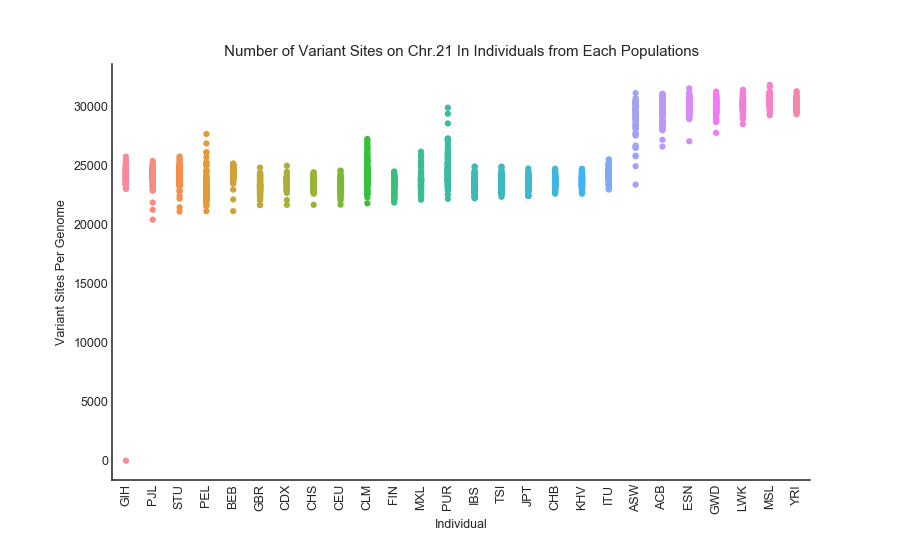

In [9]:
plt.figure(figsize=(10,6))
sns.stripplot(x='Population', y='Var_Sites', data= var_sites2, size=5)  #store an array of all the strip objects

# Modify Graph Aesthetics
sns.set_style('white')
sns.set_palette("Paired", 4)
plt.style.use('seaborn-colorblind')

ax = plt.gca()
ax.set_xlabel("Individual")
ax.set_ylabel("Variant Sites Per Genome")
ax.set_title(" Number of Variant Sites on Chr.21 In Individuals from Each Populations ")
plt.xticks(rotation = 'vertical')

#remove x-axis ticks and labels
plt.tick_params(top='off', bottom ='off', left ='on', right ='off', labelleft='on', labelbottom='on')
#remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Annotate each strip with its Population ??? 
"""strips aren't iterable like bars in barplots so maybe the authors did the annotation manually. I do not know ?
If I have time I'll try re-assinging the x-axis labels to numerical values so I can use ax.annotate which requires positional x,y
arguments"""

plt.show()

## Plot Excluding the Zero-Variants

<IPython.core.display.Javascript object>


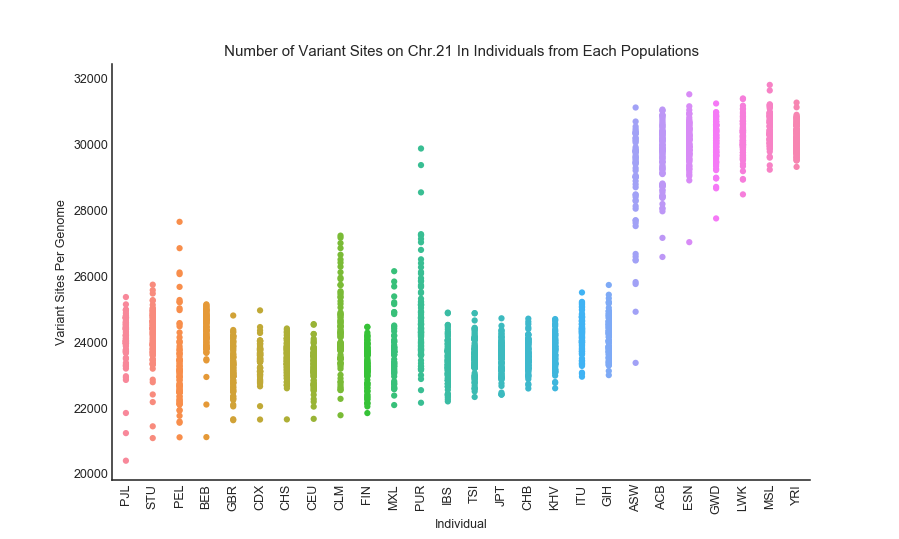

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

In [10]:
plt.figure(figsize=(10,6))
sns.stripplot(x='Population', y='Var_Sites', data= var_sites2[var_sites2.Var_Sites !=0], size=5)  #store an array of all the strip objects
sns.despine()
# Modify Graph Aesthetics
sns.set_style('white')
sns.set_palette("Paired", 4)
plt.style.use('seaborn-colorblind')

ax = plt.gca()
ax.set_xlabel("Individual")
ax.set_ylabel("Variant Sites Per Genome")
ax.set_title(" Number of Variant Sites on Chr.21 In Individuals from Each Populations ")
plt.xticks(rotation = 'vertical')

## Analysis

The top three populations with the higest number of variants were MSL, LWK, and GWD -  which are all African populations. This trend of Africans having the overall highest frequency of variants/genome is maintained on chromosome 21, even though chromosome 21 is small sample. 
The lowest three populations were CHS, GBR and CEU, the latter two are European. This trend is also observed for the total datasets. 
Overall, the trend of variants per population on chromosome 21 parallels the total dataset. 